# SIADS 591 Milestone
## Causality & Mitigations - Analysis of NYC accidents

- Amit Kumar Jha (amitjha)
- Sahil Pujari (pujari)


### Note: To run with sample dataset (quick run) modify the boolean below -

In [1]:
run_with_sample_dataset = False # Modify this for quick run

# Table of Contents
1. [Datasets](#datasets)
2. [Required packages](#required_packages)
3. [Downloading required data](#downloading_required_data)
4. [Joining Datasets](#joining_datasets)
- [Q1. Most common causes of traffic accidents in New York?](#q1_start)
- [Q2. Are there any locations which are more prone to traffic accidents than others?](#q2_start)
- [Q3. Are there any sections of society which are more prone to accidents, causal/victims like pedestrians, cyclists or bike users in specific locations?](#q3_start)
- [Q4. Attributes of vehicles with most accidents](#q4_start)
- [Q5. Traffic speed / time relation with accidents for each zip code](#q5_start)
- [Q6. Traffic count / time relation with accidents for each zip code](#q6_start)
- [Q7. Could lives be saved by quicker medical attention, i.e. hospitals closer to accident sites? Are there any locations, which do not have hospitals nearby enough](#q7_start)

## Datasets  <a class="anchor" id="datasets"></a>

In [2]:
HOSPITALS_HIFLD = 'Hospitals.csv'
MOTOR_VEHICLE_COLLISIONS_CRASHES = 'Motor_Vehicle_Collisions_-_Crashes.csv'
MOTOR_VEHICLE_COLLISIONS_PERSONS = 'Motor_Vehicle_Collisions_-_Person.csv'
MOTOR_VEHICLE_COLLISIONS_VEHICLES = 'Motor_Vehicle_Collisions_-_Vehicles.csv'
TRAFFIC_VOLUME_COUNTS = 'Traffic_Volume_Counts__2014-2019_.csv'
TRAFFIC_SPEEDS = 'DOT_Traffic_Speeds_NBE.csv'
POPULATION = 'New York City-population-2021-08-24.csv'
LINK_INFO = 'linkinfo.csv'
DRIVING_COST = 'driving_cost_countries.csv'

datasets_and_uris = {}
datasets_and_uris[HOSPITALS_HIFLD] = 'https://opendata.arcgis.com/api/v3/datasets/6ac5e325468c4cb9b905f1728d6fbf0f_0/downloads/data?format=csv&spatialRefId=3857'
datasets_and_uris[MOTOR_VEHICLE_COLLISIONS_CRASHES] = 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD'
datasets_and_uris[MOTOR_VEHICLE_COLLISIONS_PERSONS] = 'https://data.cityofnewyork.us/api/views/f55k-p6yu/rows.csv?accessType=DOWNLOAD'
datasets_and_uris[MOTOR_VEHICLE_COLLISIONS_VEHICLES] = 'https://data.cityofnewyork.us/api/views/bm4k-52h4/rows.csv?accessType=DOWNLOAD'
datasets_and_uris[TRAFFIC_VOLUME_COUNTS] = 'https://data.cityofnewyork.us/api/views/ertz-hr4r/rows.csv?accessType=DOWNLOAD'
datasets_and_uris[LINK_INFO] = 'https://data.beta.nyc/dataset/e8facf61-2bb1-49e0-9128-5a8797b214c8/resource/1384aa3a-b7e2-4c28-9b5e-2808a07a7193/download/linkinfo.csv'

## Required packages <a class="anchor" id="required_packages"></a>

In [216]:
import numpy as np
import pandas as pd
import altair as alt
import requests
import random
import os
import warnings
import calendar
import watermark
from pathlib import Path
warnings.simplefilter(action="ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import folium
from folium import plugins
import geopandas as gpd
from folium import Marker, Circle, CircleMarker, Choropleth, GeoJson, PolyLine
from folium.plugins import MarkerCluster, HeatMap
from geopandas.tools import geocode
from shapely.geometry import Point 
plt.style.use('seaborn')

from collections import Counter
from tqdm.notebook import tqdm, tqdm_notebook
import missingno as msno
from bs4 import BeautifulSoup
from scipy import stats
import re

tqdm_notebook.pandas()

from shapely.geometry import Point, Polygon, LineString
import polyline

!pip install lxml

In [4]:
# Helper routines

city_geo_dict = {}
def city_geocoder(city):
    ''' geocodes the city,
    For effecient processing, it writes the sucessful/failure geocode result in the dictionary
    And references the disctionary to check if it has been already geocoded/or not and use the result
    from earlier geocoded wheter successful or not.
    city - name of the city you wish to explore'''
    try:
        if city in city_geo_dict:
            if city_geo_dict[city]:
                result = city_geo_dict[city]
            else:
                return(None)
        else:
            result = geocode(city, provider='nominatim').geometry.iloc[0]
            city_geo_dict[city] = result
        return(result)
    except:
            city_geo_dict[city] = None
            print('could not geocode the city:', city)
    return None    
    
def geo_preprocessing(data):
    df = data.copy()
    df = df.dropna(subset=['latitude', 'longitude'])
    df['geometry'] = df.progress_apply(lambda row: Point(float(row.longitude),float(row.latitude))   \
                                if row.latitude else city_geocoder(row.borough), axis=1)
    crs = ('epsg:4326')
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=df.geometry)    
    return(gdf)    


def download_data(uri, path, filename):
    filepath = path + filename
    if os.path.isfile(filepath):
        print(filepath)
        print('file already exists, no need to download')
    else:
        result = requests.get(uri) 
        with open(filepath, 'wb') as f:
            f.write(result.content)
            
def data_cleaning(data):
    df = data.copy()
    all_columns = df.columns.to_list()
    all_columns = [col.lower().replace(' ', '_') for col in all_columns]
    df.columns = all_columns
    return(df)     

def pct_missing(data, threshold):
    'prints the missing data by percentage for the dataset'
    df = data.copy()
    for col in df.columns:
        missing_pct = np.mean(df[col].isnull())
        if missing_pct >= threshold:
            print('{} - {:.2f}%'.format(col, missing_pct*100)) 

#### Visualization Utility

In [5]:
def draw_bar(df, category, num_col, title='', reverse=False):
    bars = alt.Chart(df).mark_bar(width=25).encode(
                y= alt.Y(f'{num_col}:Q',
                     title=f'{num_col}'),
                x = alt.X(f'{category}:N',
                     sort=col_order),
                color = alt.Color(f'{category}:N',
                        scale=alt.Scale(scheme='Spectral', reverse=reverse),
                        sort=col_order)
                )
    return(bars)

def draw_text(df, category, num_col, title='', reverse=False):
    text = alt.Chart(df).mark_text(align='center', dx=5, dy=-5).encode(
                y= alt.Y(f'{num_col}:Q',
                     title=f'{num_col}'),
                x = alt.X(f'{category}:N',
                     sort=col_order),                
                text = alt.Text(f'{num_col}:Q')
                    )    
    return(text)

#### Geospatial visualization utility

In [6]:
def visualize_data_mcgroup(city, data):
    '''visualize hospital data in MarkerCluster
    city - name of the city
    hospitals - dataframe for hospital data'''
    point = city_geocoder(city)
    if not point:
        print('Please check the city/county name, Thank You.')
        return
    
    m_1 = folium.Map(location=[point.y, point.x], zoom_start=11)
    mc = MarkerCluster()
    for idx, row in data.iterrows():
        mc.add_child(Marker(location=[row['latitude'], row['longitude']]))

    m_1.add_child(mc)
    return(m_1)

def geo_heatmap(point, data):
    m = folium.Map(location=point, zoom_start=7)
    folium.plugins.HeatMap(heat_case).add_to(m)
    return(m)

def geo_clusterheatmap(point, heat_data, cluster_data):
    m = folium.Map(location=point, zoom_start=7)
    folium.plugins.HeatMap(heat_data).add_to(m)
    mc = MarkerCluster()
    for idx, row in cluster_data.iterrows():
        mc.add_child(Marker(location=[row['latitude'], row['longitude']], tooltip=row['city'], popup=row['province']))

    m.add_child(mc)
    return(m)

## Downloading required data  <a class="anchor" id="downloading_required_data"></a>

In [7]:
def download_data(uri, path, filename):
    """
    Downloads file from a direct URL
    
    @param uri: URI of the file
    @param path: path to write the file
    @param filename: Name to give the downloaded resource
    """
    filepath = path + "/" + filename
    if os.path.isfile(filepath):
        print(filepath)
        print('file already exists, no need to download')
    else:
        result = requests.get(uri) 
        with open(filepath, 'wb') as f:
            f.write(result.content)
            
if run_with_sample_dataset:
    ASSETS_PATH = 'assets/sample_datasets'
else:
    ASSETS_PATH = 'assets/datasets'

for filename, uri in datasets_and_uris.items():
    download_data(uri, ASSETS_PATH, filename)

assets/datasets/Hospitals.csv
file already exists, no need to download
assets/datasets/Motor_Vehicle_Collisions_-_Crashes.csv
file already exists, no need to download
assets/datasets/Motor_Vehicle_Collisions_-_Person.csv
file already exists, no need to download
assets/datasets/Motor_Vehicle_Collisions_-_Vehicles.csv
file already exists, no need to download
assets/datasets/Traffic_Volume_Counts__2014-2019_.csv
file already exists, no need to download
assets/datasets/linkinfo.csv
file already exists, no need to download


In [8]:
import subsample

def create_sample_csv(csv_folder_path, write_folder_path, s=1000):
    """
    Creates a random n sized row CSV sample from a given input CSV file
    
    @param csv_file_path: path of the CSV to sample
    @param s: size of sample
    """ 
    all_files = os.listdir(csv_folder_path)
    all_csv_files = [i for i in all_files if i.endswith('.csv')]
    
    for file in all_csv_files:
        filename = csv_folder_path + '/' + file
        
        ! subsample -n {s} {filename} -r > {write_folder_path + '/' + file}

# create_sample_csv('assets/datasets', 'assets/sample_datasets2')

### Convert to dataframes and postprocess / join <a class="anchor" id="joining_datasets"></a>

In [9]:
# Crashes
mv_crashes_df = pd.read_csv(ASSETS_PATH + '/' + MOTOR_VEHICLE_COLLISIONS_CRASHES, low_memory=False)
mv_crashes_df['CRASH DATE'] = pd.to_datetime(mv_crashes_df['CRASH DATE'])
mv_crashes_df.set_index('COLLISION_ID', inplace=True)

In [10]:
# Persons
mv_persons_df = pd.read_csv(ASSETS_PATH + '/' + MOTOR_VEHICLE_COLLISIONS_PERSONS, low_memory=False)
mv_persons_df.set_index('COLLISION_ID', inplace=True)

In [11]:
# Vehicles
mv_vehicles_df = pd.read_csv(ASSETS_PATH + '/' + MOTOR_VEHICLE_COLLISIONS_VEHICLES, low_memory=False)
mv_vehicles_df.set_index('COLLISION_ID', inplace=True)

In [12]:
# Join all datasets on (COLLISION_ID)
mv_combined_df = mv_crashes_df.merge(mv_persons_df, on='COLLISION_ID', how='left')
mv_combined_df = mv_combined_df.merge(mv_vehicles_df, on='COLLISION_ID', how='left')

In [13]:
sample_mv_combined_df = mv_combined_df

In [14]:
sample_mv_combined_df.head(4).to_dict()

{'CRASH DATE': {4407480.0: Timestamp('2021-04-14 00:00:00'),
  4407147.0: Timestamp('2021-04-13 00:00:00'),
  4407665.0: Timestamp('2021-04-15 00:00:00')},
 'CRASH TIME': {4407480.0: '5:32', 4407147.0: '21:35', 4407665.0: '16:15'},
 'BOROUGH': {4407480.0: nan, 4407147.0: 'BROOKLYN', 4407665.0: nan},
 'ZIP CODE': {4407480.0: nan, 4407147.0: '11217', 4407665.0: nan},
 'LATITUDE': {4407480.0: nan, 4407147.0: 40.68358, 4407665.0: nan},
 'LONGITUDE': {4407480.0: nan, 4407147.0: -73.97617, 4407665.0: nan},
 'LOCATION': {4407480.0: nan,
  4407147.0: '(40.68358, -73.97617)',
  4407665.0: nan},
 'ON STREET NAME': {4407480.0: 'BRONX WHITESTONE BRIDGE',
  4407147.0: nan,
  4407665.0: 'HUTCHINSON RIVER PARKWAY'},
 'CROSS STREET NAME': {4407480.0: nan, 4407147.0: nan, 4407665.0: nan},
 'OFF STREET NAME': {4407480.0: nan,
  4407147.0: '620       ATLANTIC AVENUE               ',
  4407665.0: nan},
 'NUMBER OF PERSONS INJURED': {4407480.0: 0.0, 4407147.0: 1.0, 4407665.0: 0.0},
 'NUMBER OF PERSONS KILL

## Q1. Most common causes of traffic accidents in New York? <a class="anchor" id="q1_start"></a>

### Contributing Factors

In [15]:
from collections import Counter

# For the purpose of finding prominent contributing factors, we need to combine X / Y parties of the accident
contributing_factor_1_y = sample_mv_combined_df['CONTRIBUTING_FACTOR_1_y'].value_counts().to_dict()
contributing_factor_2_y = sample_mv_combined_df['CONTRIBUTING_FACTOR_2_y'].value_counts().to_dict()
# Combine with vehicle factors
cf_vehicle_1 = sample_mv_combined_df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().to_dict()
cf_vehicle_2 = sample_mv_combined_df['CONTRIBUTING FACTOR VEHICLE 2'].value_counts().to_dict()
cf_vehicle_3 = sample_mv_combined_df['CONTRIBUTING FACTOR VEHICLE 3'].value_counts().to_dict()
cf_vehicle_4 = sample_mv_combined_df['CONTRIBUTING FACTOR VEHICLE 4'].value_counts().to_dict()
cf_vehicle_5 = sample_mv_combined_df['CONTRIBUTING FACTOR VEHICLE 5'].value_counts().to_dict()
# Create a combined freq dict
cf_combined = Counter(contributing_factor_1_y) + Counter(contributing_factor_2_y) + Counter(cf_vehicle_1) + Counter(cf_vehicle_2) + Counter(cf_vehicle_3) + Counter(cf_vehicle_4) + Counter(cf_vehicle_5)
del cf_combined['Unspecified']

# Top 10 contributing factors
cf_combined.most_common(10)

[('Driver Inattention/Distraction', 2347713),
 ('Following Too Closely', 877284),
 ('Failure to Yield Right-of-Way', 625684),
 ('Other Vehicular', 450422),
 ('Passing or Lane Usage Improper', 362712),
 ('Backing Unsafely', 355870),
 ('Unsafe Lane Changing', 297582),
 ('Passing Too Closely', 292179),
 ('Turning Improperly', 265891),
 ('Traffic Control Disregarded', 207199)]

### Bar Chart contributing factors

In [16]:
# Create mapping for the contributing factor strings to fit in the heatmap / future analysis
all_factors_list = cf_combined.keys()
# factors_to_int_mapping = dict([(y,x+1) for x,y in enumerate(sorted(set(all_factors_list)))])

cf_combined_df = pd.DataFrame(cf_combined.items(), columns=['Factor', 'Count'])

alt.Chart(cf_combined_df.nlargest(10, columns=['Count'])).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Factor:N', sort='-x')
)

alt.Chart(...)

### Pre-Crash Most Common Events

In [17]:
pre_crash_combined = Counter(sample_mv_combined_df['PRE_CRASH'].value_counts().to_dict())

pre_crash_combined_df = pd.DataFrame(pre_crash_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
pre_crash_combined.most_common(10)

[('Going Straight Ahead', 2224596),
 ('Parked', 636516),
 ('Making Left Turn', 271254),
 ('Stopped in Traffic', 242012),
 ('Making Right Turn', 229121),
 ('Slowing or Stopping', 191615),
 ('Backing', 150418),
 ('Changing Lanes', 144493),
 ('Merging', 78976),
 ('Starting from Parking', 77555)]

In [18]:
alt.Chart(pre_crash_combined_df.nlargest(10, columns=['Count'])).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Factor:N', sort='-x')
)

alt.Chart(...)

### Most Common - Emotional Status / Bodily Injuries

In [19]:
# Emotional Status (Ignoring Conscious)
emotional_status_combined = Counter(sample_mv_combined_df['EMOTIONAL_STATUS'].value_counts().to_dict())
emotional_status_combined.pop('Does Not Apply', None)
emotional_status_combined.pop('Unknown', None)
emotional_status_combined.pop('Conscious', None)
emotional_status_combined_df = pd.DataFrame(emotional_status_combined.items(), columns=['Factor', 'Count'])
emotional_status_combined_df.set_index('Factor', inplace=True)
# Top 10 pre crash events
emotional_status_combined.most_common(10)

[('Shock', 4806),
 ('Semiconscious', 1199),
 ('Unconscious', 989),
 ('Incoherent', 828),
 ('Apparent Death', 751)]

<AxesSubplot:ylabel='Count'>

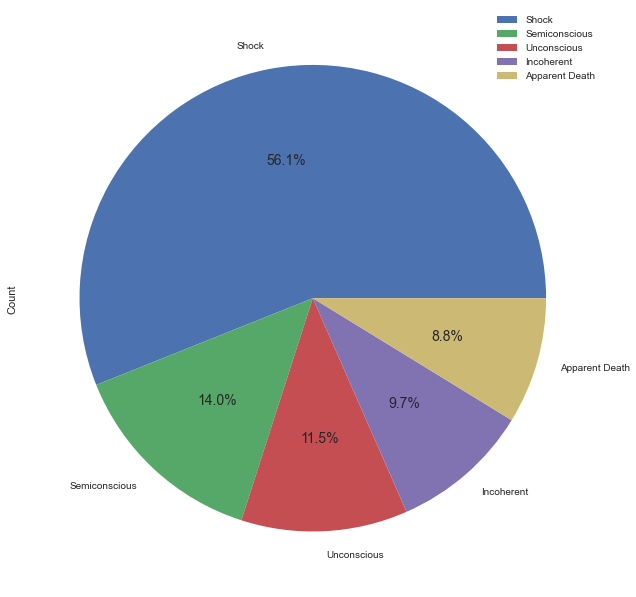

In [219]:
emotional_status_combined_df.plot.pie(x='Factor', y='Count', figsize=(10, 10), autopct='%1.1f%%')

In [21]:
# Bodily Injury
bodily_injury_combined = Counter(sample_mv_combined_df['BODILY_INJURY'].value_counts().to_dict())
bodily_injury_combined.pop('Does Not Apply', None)
bodily_injury_combined.pop('Unknown', None)
bodily_injury_combined_df = pd.DataFrame(bodily_injury_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
bodily_injury_combined.most_common(10)

[('Neck', 40302),
 ('Back', 37122),
 ('Head', 27890),
 ('Knee-Lower Leg Foot', 25256),
 ('Entire Body', 17155),
 ('Shoulder - Upper Arm', 13481),
 ('Elbow-Lower-Arm-Hand', 12768),
 ('Chest', 8623),
 ('Hip-Upper Leg', 6038),
 ('Face', 5486)]

In [22]:
alt.Chart(bodily_injury_combined_df).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Factor:N', sort='-x')
)

alt.Chart(...)

### Pedestrian | Most Common - Pre-Crash Pedestrian Action

In [24]:
# What pedestrian was doing before the crash
ped_action_combined = Counter(sample_mv_combined_df['PED_ACTION'].value_counts().to_dict())
ped_action_combined.pop('Does Not Apply', None)
ped_action_combined.pop('Unknown', None)
ped_action_combined_combined_df = pd.DataFrame(ped_action_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
ped_action_combined.most_common(10)

[('Crossing With Signal', 9346),
 ('Crossing, No Signal, or Crosswalk', 4574),
 ('Other Actions in Roadway', 2355),
 ('Crossing, No Signal, Marked Crosswalk', 2098),
 ('Crossing Against Signal', 2077),
 ('Not in Roadway', 1597),
 ('Emerging from in Front of/Behind Parked Vehicle', 982),
 ('Working in Roadway', 431),
 ('Getting On/Off Vehicle Other Than School Bus', 377),
 ('Riding/Walking Along Highway With Traffic', 262)]

In [25]:
alt.Chart(ped_action_combined_combined_df).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Factor:N', sort='-x')
)

alt.Chart(...)

### Driver | License Status - Guaging driving prowess

In [27]:
dl_status_combined = Counter(sample_mv_combined_df['DRIVER_LICENSE_STATUS'].value_counts().to_dict())
dl_status_combined.pop('Does Not Apply', None)
dl_status_combined.pop('Unknown', None)
dl_status_combined_df = pd.DataFrame(dl_status_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
dl_status_combined.most_common(10)

[('Licensed', 2974413), ('Unlicensed', 48223), ('Permit', 21122)]

In [28]:
alt.Chart(dl_status_combined_df).mark_bar().encode(
    x='Count:Q',
    y=alt.Y('Factor:N', sort='-x')
)

alt.Chart(...)

In [30]:
dl_status_combined = Counter(sample_mv_combined_df['DRIVER_LICENSE_STATUS'].value_counts().to_dict())
dl_status_combined.pop('Does Not Apply', None)
dl_status_combined.pop('Unknown', None)
dl_status_combined_df = pd.DataFrame(dl_status_combined.items(), columns=['Factor', 'Count'])

overall_count = dl_status_combined_df['Count'].sum()
licensed_count = dl_status_combined_df[dl_status_combined_df['Factor'] == 'Licensed']['Count'].sum()
unlicensed_count = dl_status_combined_df[dl_status_combined_df['Factor'] == 'Unlicensed']['Count'].sum()



### Driver | Age - Guaging driving prowess

In [31]:
dl_age_combined = Counter(sample_mv_combined_df['PERSON_AGE'].value_counts().to_dict())
dl_age_combined.pop(0.0, None)

dl_age_clean = Counter({})

for key, value in dl_age_combined.items():
    if key >= 10 and key <= 100:
        dl_age_clean[key] = value

dl_age_combined = dl_age_clean

# Create bins of 5 year range
dl_age_combined_df_raw = pd.DataFrame(dl_age_combined.items(), columns=['Factor', 'Count'])
dl_age_combined_df = dl_age_combined_df_raw.copy()
dl_age_combined_df['age_bin'] = pd.qcut(dl_age_combined_df['Factor'], q=20)
dl_age_combined_df['age_range'] = dl_age_combined_df.apply(lambda row: str(row.age_bin.left) + '-' + str(row.age_bin.right), axis=1)
dl_age_combined_df['age_range'] = dl_age_combined_df['age_range'].astype(str)
dl_age_combined_df = dl_age_combined_df.drop('age_bin', 1)
# Top 10 pre crash events
(dl_age_combined_df.groupby(['age_range'], sort=False)['Count'].sum()).nlargest(10)

age_range
23.5-28.0    315261
32.5-37.0    283613
28.0-32.5    255352
41.5-46.0    233891
50.5-55.0    225098
37.0-41.5    203211
46.0-50.5    185677
19.0-23.5    173790
55.0-59.5    154607
59.5-64.0    147963
Name: Count, dtype: int64

In [32]:
alt.Chart(dl_age_combined_df).mark_bar().encode(
    x='sum(Count)',
    y=alt.Y('age_range:N',sort='-x')
)

alt.Chart(...)

## Q2. Are there any locations which are more prone to traffic accidents than others? <a class="anchor" id="q2_start"></a>

### Pedestrian | Location:  Location of pedestrian at time of accident

In [33]:
ped_loc_combined = Counter(sample_mv_combined_df['PED_LOCATION'].value_counts().to_dict())
ped_loc_combined.pop('Does Not Apply', None)
ped_loc_combined.pop('Unknown', None)
ped_loc_combined_df = pd.DataFrame(ped_loc_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
ped_loc_combined.most_common(10)

[('Pedestrian/Bicyclist/Other Pedestrian at Intersection', 15751),
 ('Pedestrian/Bicyclist/Other Pedestrian Not at Intersection', 9384)]

<AxesSubplot:ylabel='Count'>

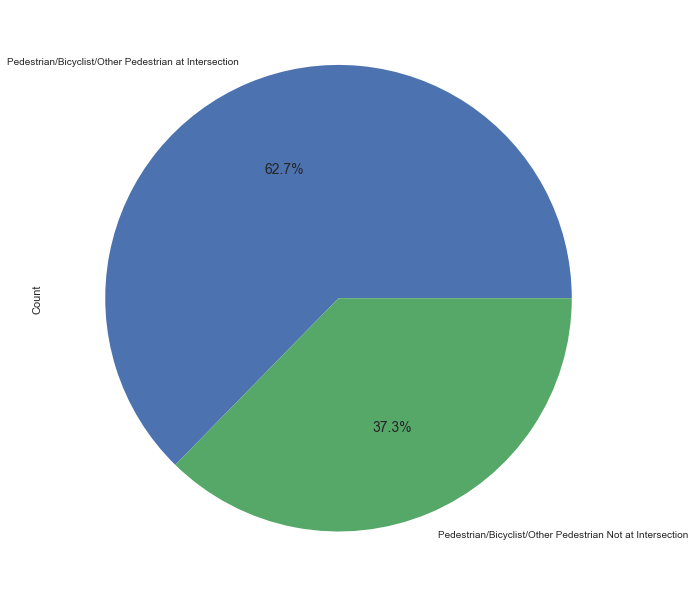

In [220]:
ped_loc_combined_pie_df = ped_loc_combined_df.copy()
ped_loc_combined_pie_df.set_index('Factor', inplace=True)
ped_loc_combined_pie_df.plot.pie(x='Factor', y='Count', figsize=(10, 10), autopct='%1.1f%%', legend=False)

### Street | Location:  Street with most crashes

In [35]:
street_loc_combined = Counter(sample_mv_combined_df['ON STREET NAME'].value_counts().to_dict())
street_loc_combined.pop('Does Not Apply', None)
street_loc_combined.pop('Unknown', None)
street_loc_combined_df = pd.DataFrame(street_loc_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
street_loc_combined.most_common(10)

[('BELT PARKWAY                    ', 63525),
 ('BROADWAY                        ', 48233),
 ('ATLANTIC AVENUE                 ', 46563),
 ('LONG ISLAND EXPRESSWAY          ', 44877),
 ('BROOKLYN QUEENS EXPRESSWAY      ', 42345),
 ('GRAND CENTRAL PKWY              ', 38453),
 ('3 AVENUE                        ', 37770),
 ('NORTHERN BOULEVARD              ', 35293),
 ('FDR DRIVE                       ', 34101),
 ('LINDEN BOULEVARD                ', 30858)]

In [36]:
alt.Chart(street_loc_combined_df.nlargest(25, 'Count')).mark_bar().encode(
    x='sum(Count)',
    y=alt.Y('Factor:N',sort='-x')
)

alt.Chart(...)

### Borough | Location:  Boroughs with most crashes

In [37]:
borough_loc_combined = Counter(sample_mv_combined_df['BOROUGH'].value_counts().to_dict())
borough_loc_combined.pop('Does Not Apply', None)
borough_loc_combined.pop('Unknown', None)
borough_loc_combined_df = pd.DataFrame(borough_loc_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
borough_loc_combined.most_common(10)

[('BROOKLYN', 1127106),
 ('QUEENS', 960668),
 ('MANHATTAN', 775238),
 ('BRONX', 522940),
 ('STATEN ISLAND', 147395)]

<AxesSubplot:ylabel='Count'>

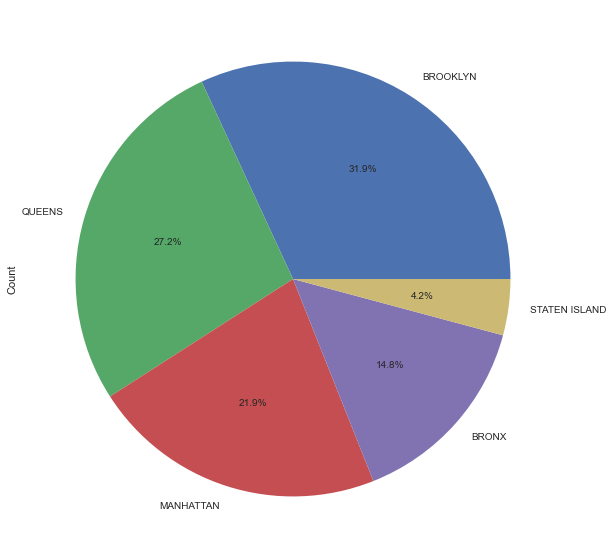

In [38]:
borough_loc_combined_pie_df = borough_loc_combined_df.copy()
borough_loc_combined_pie_df.set_index('Factor', inplace=True)
borough_loc_combined_pie_df.plot.pie(x='Factor', y='Count', figsize=(10, 10), autopct='%1.1f%%', legend=False)

### New York | Location:  Crashes across all of New York

In [39]:
# Commenting for file size

# new_york = city_geocoder('New York')
# m_1 = folium.Map(location=[new_york.y, new_york.x], tiles='OpenStreetMap', zoom_start=10)

# lat_long_df = sample_mv_combined_df[sample_mv_combined_df['LATITUDE'].notnull()]

# mc = MarkerCluster()
# for idx, row in lat_long_df.iterrows():
#     mc.add_child(Marker([row['LATITUDE'], row['LONGITUDE']]))

# m_1.add_child(mc)

## Q3. Are there any sections of society which are more prone to accidents, causal/victims like pedestrians, cyclists or bike users in specific locations?
 <a class="anchor" id="q3_start"></a>

### Injury | Comparison:  Comparing injury count of different victims

In [40]:
injury_persons_combined = Counter(sample_mv_combined_df['NUMBER OF PERSONS INJURED'].value_counts().to_dict())
injury_pedestrians_combined = Counter(sample_mv_combined_df['NUMBER OF PEDESTRIANS INJURED'].value_counts().to_dict())
injury_cyclists_combined = Counter(sample_mv_combined_df['NUMBER OF CYCLIST INJURED'].value_counts().to_dict())
injury_motorists_combined = Counter(sample_mv_combined_df['NUMBER OF MOTORIST INJURED'].value_counts().to_dict())

injury_comparison_combined_df = pd.DataFrame(injury_persons_combined.items(), columns=['Category', 'Count'])
injury_comparison_combined_df['Victim'] = 'Persons'
df  = pd.DataFrame(injury_pedestrians_combined.items(), columns=['Category', 'Count'])
df['Victim'] = 'Pedestrians'
injury_comparison_combined_df = pd.concat([injury_comparison_combined_df, df], axis =0).reset_index(drop=True)

df  = pd.DataFrame(injury_cyclists_combined.items(), columns=['Category', 'Count'])
df['Victim'] = 'Cyclist'
injury_comparison_combined_df = pd.concat([injury_comparison_combined_df, df], axis =0).reset_index(drop=True)

df  = pd.DataFrame(injury_motorists_combined.items(), columns=['Category', 'Count'])
df['Victim'] = 'Motorist'
injury_comparison_combined_df = pd.concat([injury_comparison_combined_df, df], axis =0).reset_index(drop=True)
injury_comparison_combined_df = injury_comparison_combined_df[injury_comparison_combined_df.Category != 0.0]
injury_comparison_combined_df

,Category,Count,Victim
1,1.0,772249,Persons
2,2.0,223144,Persons
3,3.0,92778,Persons
4,4.0,42682,Persons
5,5.0,21470,Persons
...,...,...,...
67,31.0,58,Motorist
68,30.0,42,Motorist
69,22.0,40,Motorist
70,43.0,34,Motorist


In [41]:
all_vals_category = injury_comparison_combined_df['Category'].unique()

charts = []

for val in all_vals_category:
    chart = alt.Chart(injury_comparison_combined_df[injury_comparison_combined_df['Category'] == val]).mark_bar().encode(
        x='Victim:O',
        y='sum(Count):Q',
        color='Victim:N',
        column='Category:N'
    )

    chart.display()

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

## Q4. Attributes of vehicles with most accidents <a class="anchor" id="q4_start"></a>

### Vehicle | Type:  Comparing crashes by vehicle types

In [42]:
vehicle_types_combined = Counter(sample_mv_combined_df['VEHICLE_TYPE'].value_counts().to_dict())
vehicle_types_combined.pop('Does Not Apply', None)
vehicle_types_combined.pop('Unknown', None)
vehicle_types_combined_df = pd.DataFrame(vehicle_types_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
vehicle_types_combined.most_common(10)

[('Sedan', 1530139),
 ('Station Wagon/Sport Utility Vehicle', 1269262),
 ('PASSENGER VEHICLE', 787918),
 ('SPORT UTILITY / STATION WAGON', 345522),
 ('4 dr sedan', 158829),
 ('Taxi', 155355),
 ('Pick-up Truck', 107306),
 ('UNKNOWN', 106104),
 ('Bus', 75675),
 ('Box Truck', 75268)]

In [43]:
alt.Chart(vehicle_types_combined_df.nlargest(10, 'Count')).mark_bar().encode(
    x='sum(Count)',
    y=alt.Y('Factor:N',sort='-x')
).properties(
    width=700,
    height=500
)

alt.Chart(...)

### Vehicle | Makes:  Comparing crashes by vehicle makes

In [44]:
vehicle_makes_combined = Counter(sample_mv_combined_df['VEHICLE_MAKE'].value_counts().to_dict())
vehicle_makes_combined.pop('Does Not Apply', None)
vehicle_makes_combined.pop('Unknown', None)
vehicle_makes_combined_df = pd.DataFrame(vehicle_makes_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
vehicle_makes_combined.most_common(10)

[('TOYT -CAR/SUV', 618888),
 ('HOND -CAR/SUV', 427161),
 ('NISS -CAR/SUV', 363818),
 ('FORD -CAR/SUV', 303790),
 ('CHEV -CAR/SUV', 172894),
 ('HYUN -CAR/SUV', 123700),
 ('MERZ -CAR/SUV', 110916),
 ('JEEP -CAR/SUV', 110357),
 ('BMW -CAR/SUV', 109620),
 ('DODG -CAR/SUV', 93772)]

In [45]:
alt.Chart(vehicle_makes_combined_df.nlargest(8, 'Count')).mark_bar().encode(
    x='sum(Count)',
    y=alt.Y('Factor:N',sort='-x')
).properties(
    width=700,
    height=500
)

alt.Chart(...)

### Vehicle Market Share | Makes:  Comparing market share of vehicle makes in the dataset

In [46]:
all_vehicle_count = vehicle_makes_combined_df['Count'].sum()
vehicle_makes_combined_df['vehicle_share'] = vehicle_makes_combined_df.apply(lambda row: (row.Count / all_vehicle_count) * 100, axis=1)

vehicle_makes_combined_df.nlargest(10, 'vehicle_share')

,Factor,Count,vehicle_share
0,TOYT -CAR/SUV,618888,17.635563
1,HOND -CAR/SUV,427161,12.172194
2,NISS -CAR/SUV,363818,10.367200
3,FORD -CAR/SUV,303790,8.656668
4,CHEV -CAR/SUV,172894,4.926712
5,HYUN -CAR/SUV,123700,3.524901
6,MERZ -CAR/SUV,110916,3.160614
7,JEEP -CAR/SUV,110357,3.144685
8,BMW -CAR/SUV,109620,3.123684
9,DODG -CAR/SUV,93772,2.672086


### Vehicle | Year:  Comparing crashes by vehicle year

In [47]:
vehicle_year_combined = Counter(sample_mv_combined_df['VEHICLE_YEAR'].value_counts().to_dict())
vehicle_year_combined.pop('Does Not Apply', None)
vehicle_year_combined.pop('Unknown', None)
vehicle_year_combined_df = pd.DataFrame(vehicle_year_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
vehicle_year_combined.most_common(10)

[(2015.0, 373321),
 (2016.0, 372704),
 (2017.0, 306828),
 (2014.0, 274333),
 (2013.0, 228231),
 (2012.0, 181750),
 (2018.0, 177631),
 (2011.0, 161690),
 (2007.0, 151444),
 (2008.0, 143462)]

In [48]:
alt.Chart(vehicle_year_combined_df.nlargest(10, 'Count')).mark_bar().encode(
    x='sum(Count)',
    y=alt.Y('Factor:N',sort='-x')
).properties(
    width=700,
    height=500
)

alt.Chart(...)

### Vehicle Market Share | Year:  Comparing market share of vehicle years in the dataset

In [49]:
all_vehicle_count = vehicle_year_combined_df['Count'].sum()
vehicle_year_combined_df['vehicle_share'] = vehicle_year_combined_df.apply(lambda row: (row.Count / all_vehicle_count) * 100, axis=1)

vehicle_year_combined_df.nlargest(10, 'vehicle_share')

,Factor,Count,vehicle_share
0,2015.0,373321,10.653451
1,2016.0,372704,10.635844
2,2017.0,306828,8.755942
3,2014.0,274333,7.828633
4,2013.0,228231,6.513022
5,2012.0,181750,5.186595
6,2018.0,177631,5.069051
7,2011.0,161690,4.614143
8,2007.0,151444,4.321753
9,2008.0,143462,4.093971


### Vehicle | Make & Year:  Comparing crashes by vehicle make and year

In [50]:
vehicle_make_year_raw_df = sample_mv_combined_df.copy()
vehicle_make_year_raw_df.dropna(subset=['VEHICLE_MAKE'], inplace=True)
vehicle_make_year_raw_df.dropna(subset=['VEHICLE_YEAR'], inplace=True)

vehicle_make_year_raw_df['VEHICLE_MAKE_YEAR'] = vehicle_make_year_raw_df.apply(lambda row: str(row['VEHICLE_MAKE']) + ' | ' + str(row['VEHICLE_YEAR']), axis=1)

vehicle_make_year_combined = Counter(vehicle_make_year_raw_df['VEHICLE_MAKE_YEAR'].value_counts().to_dict())
vehicle_make_year_combined.pop('Does Not Apply', None)
vehicle_make_year_combined.pop('Unknown', None)
vehicle_make_year_combined_df = pd.DataFrame(vehicle_make_year_combined.items(), columns=['Factor', 'Count'])

# Top 10 pre crash events
vehicle_make_year_combined.most_common(15)

[('TOYT -CAR/SUV | 2015.0', 91894),
 ('TOYT -CAR/SUV | 2014.0', 69901),
 ('TOYT -CAR/SUV | 2016.0', 67988),
 ('TOYT -CAR/SUV | 2017.0', 53995),
 ('HOND -CAR/SUV | 2016.0', 47731),
 ('TOYT -CAR/SUV | 2013.0', 43391),
 ('NISS -CAR/SUV | 2016.0', 42876),
 ('NISS -CAR/SUV | 2015.0', 42621),
 ('HOND -CAR/SUV | 2017.0', 37509),
 ('HOND -CAR/SUV | 2015.0', 36972),
 ('TOYT -CAR/SUV | 2012.0', 34528),
 ('NISS -CAR/SUV | 2017.0', 33075),
 ('NISS -CAR/SUV | 2014.0', 31366),
 ('FORD -CAR/SUV | 2016.0', 29408),
 ('TOYT -CAR/SUV | 2018.0', 28658)]

### Vehicle Market Share | Make & Year:  Comparing market share of vehicle make and year combinations in the dataset

In [51]:
all_vehicle_count = vehicle_make_year_combined_df['Count'].sum()
vehicle_make_year_combined_df['vehicle_share'] = vehicle_make_year_combined_df.apply(lambda row: (row.Count / all_vehicle_count) * 100, axis=1)

vehicle_make_year_combined_df.nlargest(10, 'vehicle_share')

,Factor,Count,vehicle_share
0,TOYT -CAR/SUV | 2015.0,91894,2.654431
1,TOYT -CAR/SUV | 2014.0,69901,2.019146
2,TOYT -CAR/SUV | 2016.0,67988,1.963887
3,TOYT -CAR/SUV | 2017.0,53995,1.559688
4,HOND -CAR/SUV | 2016.0,47731,1.378748
5,TOYT -CAR/SUV | 2013.0,43391,1.253383
6,NISS -CAR/SUV | 2016.0,42876,1.238507
7,NISS -CAR/SUV | 2015.0,42621,1.231141
8,HOND -CAR/SUV | 2017.0,37509,1.083477
9,HOND -CAR/SUV | 2015.0,36972,1.067965


### Traffic Data Processing

In [52]:
# download traffic speed datasets
def get_traffic_speed_uris(nyc_traffic_speed_uri):
    traffic_speed_webpage = requests.get(nyc_traffic_speed_uri)
    soup = BeautifulSoup(traffic_speed_webpage.content, 'lxml')
    links = []
    months_lower = []
    for month in calendar.month_name[1:]:
        months_lower.append(month.lower())
    # print(months_lower)    
    for link in soup.findAll('a'):
        plausible_link = link['href']
        download_year_cond = ('2021' not in plausible_link) and ('2020' not in plausible_link)
        if '.csv' in plausible_link and any(x for x in months_lower if x in plausible_link) and download_year_cond:
            links.append(link.get('href'))      
    return(links)

def download_traffic_speed_data(uris, year_range):
    """
    Download traffic_speed dataset for the year range
    @param uris: URIs of the monthly traffic speed datasets
    @param year_range: range of years for which we want to download the traffic speed dataset 
    """
    for TRAFFIC_SPEED_URI in datasets_and_uris['TRAFFIC_SPEED']:
        filename = TRAFFIC_SPEED_URI.split('/')[-1]
        if not any(year for year in year_range if str(year) in filename):
            filename = filename.split('.')[0] + '2015' + '.csv'
#             print(filename)
        download_data(TRAFFIC_SPEED_URI, ASSETS_PATH, filename)  

# Get the URIs for all the monthly traffic_speed datasets from the NYC beta site using webscrapping
# NYC_TRAFFIC_SPEED_ARCHIVE = 'https://data.beta.nyc/dataset/nyc-real-time-traffic-speed-data-feed-archived'
# datasets_and_uris['TRAFFIC_SPEED'] = get_traffic_speed_uris(NYC_TRAFFIC_SPEED_ARCHIVE)

# year_range = [year for year in range(2015, 2020)]        
# download_traffic_speed_data(datasets_and_uris['TRAFFIC_SPEED'], year_range)        

#### Read the driving cost dataset(self created)
 - https://www.insider.com/countries-cost-price-driver-license-comparison-2018-9#getting-a-drivers-license-in-thailand-costs-about-605-thb-which-is-about-1869-20

In [53]:
driving_cost = pd.read_csv(ASSETS_PATH + '/' + DRIVING_COST)
driving_cost = driving_cost.drop(columns=['LicenseCostMin', 'LicenseCostMax', 'Currency'], axis=1)
driving_cost = driving_cost.dropna()
driving_cost['Country'] = driving_cost.astype('string')
driving_cost.head()

,Country,LicenseCostAvg
0,NYC,90.0
1,United States,510.0
2,Canada,67.0
3,Russia,577.0
4,UK,163.0


#### Read the traffic_volume dataset

In [54]:
traffic_volume_df = pd.read_csv(ASSETS_PATH + '/' + TRAFFIC_VOLUME_COUNTS, low_memory=False)
traffic_volume_df.head(3)

,ID,Segment ID,Roadway Name,From,To,Direction,Date,12:00-1:00 AM,1:00-2:00AM,2:00-3:00AM,...,2:00-3:00PM,3:00-4:00PM,4:00-5:00PM,5:00-6:00PM,6:00-7:00PM,7:00-8:00PM,8:00-9:00PM,9:00-10:00PM,10:00-11:00PM,11:00-12:00AM
0,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,09/13/2014,204.0,177.0,133.0,...,520,611,573,546,582,528,432,328,282,240
1,2,70376,3 Avenue,East 155 Street,East 154 Street,SB,09/13/2014,140.0,51.0,128.0,...,379,376,329,362,418,335,282,247,237,191
2,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,EB,09/13/2014,94.0,73.0,65.0,...,280,272,264,236,213,190,199,183,147,103


#### Read the link_info dataset

In [55]:
# "linkId","linkPoints","EncodedPolyLine","EncodedPolyLineLvls","Transcom_id","Borough","linkName","Owner"
cols_to_use = ['linkId','linkPoints', 'EncodedPolyLine','EncodedPolyLineLvls', 'Borough']
col_dtype = {'linkId':np.int32, 'linkPoints':'string', 'EncodedPolyLine':'string', 'EncodedPolyLineLvls':'string', \
                 'Borough':'string'}
linkinfo_df = pd.read_csv(ASSETS_PATH + '/' + LINK_INFO, usecols=cols_to_use, dtype=col_dtype)
linkinfo_df.head()

,linkId,linkPoints,EncodedPolyLine,EncodedPolyLineLvls,Borough
0,4616337,"40.74047,-74.009251 40.74137,-74.00893 40.7431...",}btwFx|ubMsD_AgJcAcR{ByJ_AsBFiEbByCXaFuAkLiDsT...,BBBBBBBBBBBBB,Manhattan
1,4616325,"40.73933,-74.01004 40.73895,-74.01012 40.7376,...",y{swFvavbMjANlGSvQn@fa@fBhQdA,BBBBBB,Manhattan
2,4616324,"40.76375,-73.999191 40.763521,-73.99935 40.762...",mtxwF|}sbMl@^~GpK|LrIbLlH??lK~G|FtD`C~@}@WdWnG...,BBBBBBBBBBBBBBB,Manhattan
3,4616338,"40.7607,-74.002141 40.76212,-74.91 40.76335,-7...",kaxwFjptbM{GuFuFgIwHsFmJqG_OwJcCw@qE[cBc@,BBBBBBBBB,Manhattan
4,4616323,"40.77158,-73.994441 40.7713004,-73.99455 40.77...",kezwFf`sbMv@TxAVnDZe@Gz@J~@Xf@VlEnC??~KpH??vCp...,BBBBBBBBBBBBBBBBB,Manhattan


In [56]:
def linkinfo_processing(enc_poly):
    try:            
        link_points = polyline.decode(enc_poly)
    except:
        # escape charaters if normal decoding is failed
        try:
            link_points = polyline.decode(re.escape(x))
        except:
            pass
            print('could not decode encoded polyline')
#             print(indx, enc_poly)
            return(None, None, None, None)

    link_points = sorted(link_points)
    lat_min = link_points[0][0]
    lat_max = link_points[-1][0]
    long_min = link_points[0][1]
    long_max = link_points[-1][1] 
    return(lat_max, lat_min, long_max, long_min)

linkinfo_df['lat_max'], linkinfo_df['lat_min'], linkinfo_df['long_max'],    \
                linkinfo_df['long_min'] =   zip(*linkinfo_df['EncodedPolyLine'].map(linkinfo_processing))

linkinfo_df = linkinfo_df.dropna(subset=['lat_max', 'lat_min'])
linkinfo_df.head(3)

could not decode encoded polyline
could not decode encoded polyline


,linkId,linkPoints,EncodedPolyLine,EncodedPolyLineLvls,Borough,lat_max,lat_min,long_max,long_min
0,4616337,"40.74047,-74.009251 40.74137,-74.00893 40.7431...",}btwFx|ubMsD_AgJcAcR{ByJ_AsBFiEbByCXaFuAkLiDsT...,BBBBBBBBBBBBB,Manhattan,40.76074,40.74047,-74.00208,-74.00925
1,4616325,"40.73933,-74.01004 40.73895,-74.01012 40.7376,...",y{swFvavbMjANlGSvQn@fa@fBhQdA,BBBBBB,Manhattan,40.73933,40.72619,-74.01004,-74.01113
2,4616324,"40.76375,-73.999191 40.763521,-73.99935 40.762...",mtxwF|}sbMl@^~GpK|LrIbLlH??lK~G|FtD`C~@}@WdWnG...,BBBBBBBBBBBBBBB,Manhattan,40.76375,40.73939,-73.99919,-74.01002


#### Read the traffic_speeds dataset

In [57]:
def read_traffic_speed_data(path, year):
    #This reads and combines monthly traffic speed dataset 
    #Check of file already read/combined
    cols_to_use = ['Speed', 'TravelTime','DataAsOf', 'linkId']
    col_dtype = {'Speed':np.float16, 'TravelTime':np.int16, 'linkId': np.int32}
    
    filename_yr = 'traffic_speed_' + str(year) + '.csv'
    filepath_yr = ASSETS_PATH + '/' + filename_yr
    if not os.path.isfile(filepath_yr):        
        months = [month.lower() for month in calendar.month_name[1:]]
        filenames = [month+str(year)+'.csv' for month in months]
        frames = [None] * len(months)
        for indx,filename in enumerate(filenames):
            filepath = ASSETS_PATH + '/' + filename
            if os.path.isfile(filepath):
                print(filename)
                try:
                # Reading files having header
                    frames[indx] = pd.read_csv(ASSETS_PATH + '/' + filename, usecols=cols_to_use, dtype=col_dtype)
                except:
                #Reading files which doesnt have header
                    frames[indx] = pd.read_csv(ASSETS_PATH + '/' + filename, header=None, usecols=[1,2,4,5],  \
                                               names=cols_to_use, low_memory=False)

        frames = [frame for frame in frames if frame is not None]
        df = pd.concat(frames)    
        df = df.convert_dtypes().dropna()
        df.to_csv(filepath_yr)
    else:
        df = pd.read_csv(filepath_yr, usecols=cols_to_use, low_memory=False)
    return(df)

# traffic_speed_2015 = read_traffic_speed_data(ASSETS_PATH, 2015)
# traffic_speed_2015.head()
# del traffic_speed_2015

#### Read poulation data

In [58]:
# download and read NYC population data
# used for normalization of crashes data
table_nyc = pd.read_html('https://www.macrotrends.net/cities/23083/new-york-city/population', \
                        match='New York City - Historical Population Data')

population = table_nyc[0]
population.columns = ['year', 'population', 'growth_rate']
population.head()

,year,population,growth_rate
0,2021,18823000,0.10%
1,2020,18804000,-0.01%
2,2019,18805000,-0.07%
3,2018,18819000,0.30%
4,2017,18762000,0.30%


In [59]:
def pop_processing(data):
    df = data.copy()
    all_columns = df.columns
    df.columns = [col.lower().strip() for col in all_columns]
#     df['date'] = pd.to_datetime(df['date'])
#     df['year'] = df.date.dt.year
    df  = df[(df['year'] >=2015) & (df['year'] < 2021)]
    df = df.drop(columns=['growth_rate']).set_index('year')
    return(df)
    
population = pop_processing(population)    
population.head()

,population
year,
2020,18804000
2019,18805000
2018,18819000
2017,18762000
2016,18705000


#### Download/Read traffic related death rate data 

In [60]:
# download and read crashes related death rate for multiple countries
death_rate_site = 'https://en.wikipedia.org/wiki/List_of_countries_by_traffic-related_death_rate'
crash_death_rate = pd.read_html(death_rate_site)[1]
crash_death_rate = crash_death_rate.drop(crash_death_rate.columns[[4, 5, 6]], axis=1).dropna()
crash_death_rate.columns = ['country', 'continent','death_rate(per_lacs_habitant_per_year)', \
                                'death_rate(per_lacs_vehicle_per_year)']
crash_death_rate.head()

,country,continent,death_rate(per_lacs_habitant_per_year),death_rate(per_lacs_vehicle_per_year)
7,Afghanistan,Asia,15.5,722.4
8,Albania,Europe,15.1,107.2
9,Algeria,Africa,23.8,127.8
10,Andorra,Europe,7.6,7.9
11,Angola,Africa,26.9,992


## Q5. Traffic count / time relation with accidents for each zip code  <a class="anchor" id="q5_start"></a>

#### Explore traffic_volume dataset

In [61]:
traffic_volume = data_cleaning(traffic_volume_df) 
del traffic_volume_df
traffic_volume.head()

,id,segment_id,roadway_name,from,to,direction,date,12:00-1:00_am,1:00-2:00am,2:00-3:00am,...,2:00-3:00pm,3:00-4:00pm,4:00-5:00pm,5:00-6:00pm,6:00-7:00pm,7:00-8:00pm,8:00-9:00pm,9:00-10:00pm,10:00-11:00pm,11:00-12:00am
0,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,09/13/2014,204.0,177.0,133.0,...,520,611,573,546,582,528,432,328,282,240
1,2,70376,3 Avenue,East 155 Street,East 154 Street,SB,09/13/2014,140.0,51.0,128.0,...,379,376,329,362,418,335,282,247,237,191
2,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,EB,09/13/2014,94.0,73.0,65.0,...,280,272,264,236,213,190,199,183,147,103
3,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,WB,09/13/2014,88.0,82.0,75.0,...,237,276,223,240,217,198,186,162,157,103
4,62,147673,Broadway,West 242 Street,240 Street,SB,09/13/2014,255.0,209.0,149.0,...,732,809,707,675,641,556,546,465,425,324


In [62]:
pct_missing(traffic_volume, 0.01)

In [63]:
def traffic_volume_processing(data):
    df = data.copy()
    all_columns = df.columns
    df['total_traffic_vol'] = pd.DataFrame([0] * len(traffic_volume))
    for col in all_columns:
        if col in ['id', 'segment_id']:
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'O':
            df[col] = df[col].astype('string')
            if col == 'roadway_name':
                df[col].apply(lambda x: ' '.join(wrd.lower() for wrd in x.split()))
        else:
            df[col] = df[col].fillna(df.groupby('id')[col].transform("mean"))
            df[col] = df[col].astype('int32')
    df['traffic_vol'] = df.iloc[:, 7:31].sum(axis=1)    
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year   
    df['month'] = df['date'].dt.month    
    return(df)

traffic_vol = traffic_volume_processing(traffic_volume)
traffic_vol.head()

,id,segment_id,roadway_name,from,to,direction,date,12:00-1:00_am,1:00-2:00am,2:00-3:00am,...,6:00-7:00pm,7:00-8:00pm,8:00-9:00pm,9:00-10:00pm,10:00-11:00pm,11:00-12:00am,total_traffic_vol,traffic_vol,year,month
0,2,70376,3 Avenue,East 154 Street,East 155 Street,NB,2014-09-13,204,177,133,...,582,528,432,328,282,240,0,8097,2014,9
1,2,70376,3 Avenue,East 155 Street,East 154 Street,SB,2014-09-13,140,51,128,...,418,335,282,247,237,191,0,6211,2014,9
2,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,EB,2014-09-13,94,73,65,...,213,190,199,183,147,103,0,3978,2014,9
3,56,176365,Bedford Park Boulevard,Grand Concourse,Valentine Avenue,WB,2014-09-13,88,82,75,...,217,198,186,162,157,103,0,4003,2014,9
4,62,147673,Broadway,West 242 Street,240 Street,SB,2014-09-13,255,209,149,...,641,556,546,465,425,324,0,11477,2014,9


In [64]:
traffic_vol['roadway_name'] = traffic_vol['roadway_name'].astype('str').str.title()
traffic_vol_roadway = traffic_vol.groupby('roadway_name')['traffic_vol'].agg('mean')     \
                        .reset_index().sort_values(by='traffic_vol', ascending=False).reset_index(drop=True)
col_order = traffic_vol_roadway.traffic_vol.to_list()
# del traffic_vol
traffic_vol_roadway['traffic_vol_lg'] = np.log(traffic_vol_roadway['traffic_vol'])
traffic_vol_roadway['expressway'] = traffic_vol_roadway['roadway_name'].apply(lambda x: 'Y' if x.find('Expressway') !=-1 else 'N')

traffic_vol_roadway.head()

,roadway_name,traffic_vol,traffic_vol_lg,expressway
0,Long Island Expressway,86620.962963,11.369297,Y
1,Staten Island Expressway,81637.638889,11.310046,Y
2,Cross Bronx Expressway,73610.592593,11.206544,Y
3,Brooklyn Queens Expressway,70464.027778,11.162858,Y
4,F D R Drive,70037.658120,11.156788,N


In [65]:
mask = traffic_vol_roadway['expressway'] == 'Y'
title = 'Traffic Volume on top 25 Expressway roads'
bar = draw_bar(traffic_vol_roadway[mask][:20], 'roadway_name','traffic_vol', title='Total Traffic Volume').mark_bar(size=15)
bar.properties(width=650,height=300, title=title)

alt.Chart(...)

In [66]:
mask = traffic_vol_roadway['expressway'] == 'N'
title = 'Traffic Volume on top 25 Non-Expressway roads'
bar = draw_bar(traffic_vol_roadway[mask][:25], 'roadway_name','traffic_vol', title='Total Traffic Volume').mark_bar(size=15)
bar.properties(width=650,height=300, title=title)

alt.Chart(...)

#### Crashes dataset exploration/cleaning/preprocessing

In [67]:
def pct_missing(data, threshold):
    'prints the missing data by percentage for the dataset'
    df = data.copy()
    print('Missing data report for datast:')
    for col in df.columns:
        missing_pct = np.mean(df[col].isnull())
        if missing_pct >= threshold:
            print('{} - {:.2f}%'.format(col, missing_pct*100)) 
            
pct_missing(crashes_df, 0.10)

NameError: name 'crashes_df' is not defined

#### Explore death rate/average licence cost in different contries

In [68]:
col_order = driving_cost['LicenseCostAvg'].sort_values(ascending=False).to_list()
bar = draw_bar(driving_cost, 'Country','LicenseCostAvg', title='')
text = draw_text(driving_cost, 'Country','LicenseCostAvg', title='')
(bar + text).properties(width=700,height=300, title='Driving Cost in Countries(in dollers)')

alt.LayerChart(...)

In [159]:
driving_cost = pd.read_csv(ASSETS_PATH + '/' + DRIVING_COST)
driving_cost = driving_cost.drop(columns=['LicenseCostMin', 'LicenseCostMax', 'Currency'], axis=1)
driving_cost = driving_cost.dropna()
driving_cost['Country'] = driving_cost.astype('string')
driving_cost.columns = ['country','license_cost']
def log_std_processing(data):
    df = data.copy()
    df = df.astype('float')
    all_columnns = list(df.columns )
    for col in all_columnns:
        df[col + '_lg'] = np.log(df[col])      
        df[col + '_std'] = (df[col] - np.mean(df[col])) / np.std(df[col])
    return(df)

def driving_cost_death_rate_relation(driving_cost, crash_death_rate):
    df = driving_cost.merge(crash_death_rate, left_on='country', right_on='country', how='left')
    df = df.drop(columns=['continent']).dropna()
    df = df.set_index('country')
    return(df)
    
driving_cost_death_rate = driving_cost_death_rate_relation(driving_cost, crash_death_rate)
driving_cost_death_rate = log_std_processing(driving_cost_death_rate)
driving_cost_death_rate

,license_cost,death_rate(per_lacs_habitant_per_year),death_rate(per_lacs_vehicle_per_year),license_cost_lg,license_cost_std,death_rate(per_lacs_habitant_per_year)_lg,death_rate(per_lacs_habitant_per_year)_std,death_rate(per_lacs_vehicle_per_year)_lg,death_rate(per_lacs_vehicle_per_year)_std
country,,,,,,,,,
United States,510.00,12.4,14.2,6.234411,-0.313490,2.517696,0.179183,2.653242,-0.520708
Canada,67.00,5.8,8.9,4.204693,-0.739084,1.757858,-0.539970,2.186051,-0.648376
Russia,577.00,11.6,50.0,6.357842,-0.249122,2.451005,0.092013,3.912023,0.341652
India,9.59,16.6,130.1,2.260721,-0.794238,2.809403,0.636826,4.868303,2.271124
Spain,1575.50,3.7,5.8,7.362328,0.710146,1.308333,-0.768792,1.757858,-0.723050
France,1507.00,5.0,8.4,7.317876,0.644338,1.609438,-0.627140,2.128232,-0.660421
Germany,3000.00,3.7,6.4,8.006368,2.078676,1.308333,-0.768792,1.856298,-0.708597
China,88.00,18.8,104.5,4.477337,-0.718909,2.933857,0.876544,4.649187,1.654464
Australia,128.00,4.5,7.4,4.852030,-0.680480,1.504077,-0.681622,2.001480,-0.684509


In [210]:
def draw_scatter_cor(col1, col2, data, title=''):
    m , b =np.polyfit(data[col1],  data[col2], 1)
    y = m * data[col1] + b
    plt.scatter(col1, col2, data=data)
    plt.plot(data[col1], y)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(title)
    plt.show()

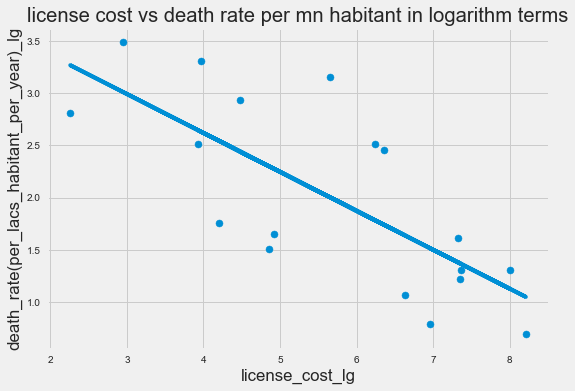

In [211]:
plt.style.use('fivethirtyeight')
title = 'license cost vs death rate per mn habitant in logarithm terms'
draw_scatter_cor('license_cost_lg', 'death_rate(per_lacs_habitant_per_year)_lg', driving_cost_death_rate, title=title)

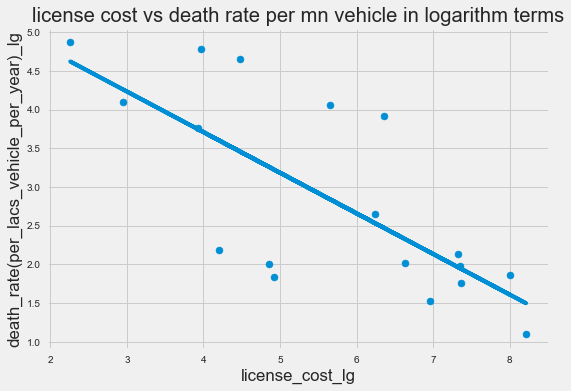

In [212]:
title = 'license cost vs death rate per mn vehicle in logarithm terms'
draw_scatter_cor('license_cost_lg', 'death_rate(per_lacs_vehicle_per_year)_lg', driving_cost_death_rate, title=title)

In [166]:
stats.pearsonr(driving_cost_death_rate['license_cost'], driving_cost_death_rate['death_rate(per_lacs_habitant_per_year)'])

(-0.5488954373932362, 0.018321068128962847)

In [168]:
stats.pearsonr(driving_cost_death_rate['license_cost'], driving_cost_death_rate['death_rate(per_lacs_vehicle_per_year)'])

(-0.5018273962959143, 0.03383974539906057)

#### There is moderate negative correlation between license cost and death rate per lacs habitat as well as vehicle per year.

Lets do a hypothesis test
<br><b>Null Hypothesis</b> - Death rate is same across different average license costs.
<br><b>Alternate Hypothesis</b> - Death rate is not same across different average license cost across different contries.

Set Alpha = 0.05

In [172]:
np.set_printoptions(suppress=True)
stats.ttest_ind(driving_cost_death_rate['license_cost'], driving_cost_death_rate['death_rate(per_lacs_habitant_per_year)'])

Ttest_indResult(statistic=3.2699832986519914, pvalue=0.0024671968283110613)

In [173]:
stats.ttest_ind(driving_cost_death_rate['license_cost'], driving_cost_death_rate['death_rate(per_lacs_vehicle_per_year)'])

Ttest_indResult(statistic=3.16832186341643, pvalue=0.003234655694685484)

<b>p-value is less than 5%(near zero), hence we reject the null hypothesis that death rates are same over different average license cost.</b>
    
     - That is we have significant evidence that death rate varies inversaly to license cost.
    
Now this may be misleading.
<br>While there is inverse correlation between average license cost and death rate, this does not mean there is causal relationship.
But what we can say, is that perhaps more training and tests require additional cost and hence cause increase in license cost which causes reduction is traffic crashes because of more skilled drivers on the road.

## Q5. Traffic speed / time relation with accidents for each zip code  <a class="anchor" id="q5_start"></a>

In [174]:
def traffic_speed_processing(data):
    df = data.copy()
    col_dtype = {'Speed':np.float16, 'TravelTime':np.int16, 'linkId': np.int32}    
    df = df[df['linkId'] != 'linkId'] 
    df['speed_date'] = pd.to_datetime(df['DataAsOf'])  
    df = df.sort_values(by='speed_date')
    df = df.drop(columns=['DataAsOf'])
    df = df.astype(col_dtype)    
    return(df)

def traffic_speed_crash_relation(crashes_gdf, years, bins):
    frames = [None] * len(years)
    for indx, year in enumerate(years):
        traffic_speed_yr = read_traffic_speed_data(ASSETS_PATH, year)
        traffic_speed_yr = traffic_speed_processing(traffic_speed_yr)
        frames[indx] = pd.merge_asof(crashes_gdf, traffic_speed_yr, left_on=['date'], \
                                              right_on=['speed_date'], by='linkId',
                                                tolerance=pd.Timedelta('5min'))

        frames[indx] = frames[indx].dropna(subset=['linkId', 'Speed'])
    frames = [frame for frame in frames if frame is not None]
    crahes_speed_df = pd.concat(frames)
    crahes_speed_df['speed_bin'] = pd.cut(crahes_speed_df['Speed'], bins=bins)
    return(crahes_speed_df)
    
def traffic_speed_crash_grp_metric(crashes_speed):
    crahes_speed_grpd = crashes_speed.groupby(['speed_bin']).agg({'number_of_persons_injured': np.sum,'number_of_persons_killed': np.sum,
                                        'number_of_pedestrians_injured':np.sum,'number_of_pedestrians_killed':np.sum,
                                        'number_of_cyclist_injured':np.sum,'number_of_cyclist_killed':np.sum,  
                                        'number_of_motorist_injured':np.sum,'number_of_motorist_killed':np.sum,  
                                        'collision_id':'count','Speed': 'mean'}).reset_index()
    
    cols_to_norm = ['number_of_persons_injured', 'number_of_persons_killed',
       'number_of_pedestrians_injured', 'number_of_pedestrians_killed',
       'number_of_cyclist_injured', 'number_of_cyclist_killed',
       'number_of_motorist_injured', 'number_of_motorist_killed']
    for col in cols_to_norm:
            crahes_speed_grpd[col + '_norm'] = crahes_speed_grpd.apply(lambda row: row[col] * 100/(row.collision_id + 1)
                                                    , axis=1).astype('int16')            
    crahes_speed_grpd['speed_upper'] = crahes_speed_grpd.speed_bin.apply(lambda x: x.right).astype('int16')
    crahes_speed_grpd = crahes_speed_grpd.dropna(subset=['Speed'])
    crahes_speed_grpd['Speed'] = crahes_speed_grpd.Speed.astype('int16')    
    return(crahes_speed_grpd)

def multiline_plot(data, category, num_col, title='', xlabel=''):
    plt.figure(figsize=(10,6))
    for col in num_col:
        plt.plot(category, col, data=data, label=col.replace('_', ' '))
    plt.legend()
    plt.ylabel('count of injured', size=13)
    plt.xlabel('Speed in miles/hr', size=13)
    plt.title(title, size=17)
    plt.show()

bins = [-np.inf] + [num for num in range(0, 140, 5)]

#### Speed vs injury/fatality relation

In [175]:
crashes_df = pd.read_csv(ASSETS_PATH + '/' + MOTOR_VEHICLE_COLLISIONS_CRASHES, parse_dates=True, low_memory=False)
crashes_df.rename(columns={'collision_crashes_nyc.csv': 'CRASH_DATE'}, inplace=True)

cols_to_drop = ['contributing_factor_vehicle_3', 'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5', \
                    'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5']

def crashes_preprocessing(data):
    df = data.copy()
    df = df.convert_dtypes()
    df['zip_code'] = df['zip_code'].astype('string')
    df['crash_date'] = pd.to_datetime(df['crash_date'])
    df['crash_time'] = df['crash_time'].fillna(np.nan)
    df = df.dropna(subset=['crash_time'])
    df['crash_time'] = pd.to_datetime(df['crash_time'], format='%H:%M')
    df['year']       = df['crash_date'].dt.year
    df['month']      = df['crash_date'].dt.month
    df['hr']         = df['crash_time'].dt.hour
    df['crash_time']       = df['crash_time'].dt.time
    df['date'] = pd.to_datetime(df['crash_date'].astype('string') + ' ' +  \
                                     df['crash_time'].astype('string'))
    df = df[(df.year >=2015) & (df.year <= 2019)]
    df = df.drop(cols_to_drop, axis=1)
    df['collision_id']
    for col in df.columns:
        if str(df[col].dtype) in ['int64', 'Int64']:
            df[col] = df[col].fillna(0)  
            if col == 'collision_id':
                df[col] = df[col].astype('int32')
            elif col in ['month', 'hr', 'min_bin']:
                df[col] = df[col].astype('int8')
            else:
                df[col] = df[col].astype('int16')
        elif str(df[col].dtype) == 'string':
            df[col] = df[col].fillna('_Missing_')    
            df[col] = df[col].apply(lambda x: x.strip().title())            
    return(df)
        
crashes_clean = data_cleaning(crashes_df)
crashes = crashes_preprocessing(crashes_clean)
# # del crashes_df
del crashes_clean
del crashes_df
crashes.head(3)

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,number_of_motorist_killed,contributing_factor_vehicle_1,contributing_factor_vehicle_2,collision_id,vehicle_type_code_1,vehicle_type_code_2,year,month,hr,date
13,2019-05-21,22:50:00,Brooklyn,11201,40.69754,-73.98312,"(40.69754, -73.98312)",Gold Street,Concord Street,_Missing_,...,0,Passing Or Lane Usage Improper,Unspecified,4136992,�Mbu,Taxi,2019,5,22,2019-05-21 22:50:00
395,2016-04-16,14:20:00,Brooklyn,11214,40.586277,-73.9862,"(40.586277, -73.9862)",West 17 Street,Bay 50 Street,_Missing_,...,0,Driver Inattention/Distraction,Unspecified,4408059,Sedan,Station Wagon/Sport Utility Vehicle,2016,4,14,2016-04-16 14:20:00
847,2019-04-17,00:49:00,_Missing_,_Missing_,40.651974,-73.86542,"(40.651974, -73.86542)",Belt Parkway,_Missing_,_Missing_,...,0,Following Too Closely,Unspecified,4408571,Station Wagon/Sport Utility Vehicle,Sedan,2019,4,0,2019-04-17 00:49:00


In [96]:
crashes_gdf = geo_preprocessing(crashes)
# del crashes
crashes_gdf.head(3)

cols_to_drop = ['crash_time', 'zip_code', 'location', 'hr']
crashes_gdf = crashes_gdf.drop(columns=cols_to_drop)

  0%|          | 0/1003236 [00:00<?, ?it/s]

In [97]:
%%time
# Get link information to be able to merge it with traffic speed dataset
# Here we are checking if crash location was on a particular polyline by checking if crash location(lat/long) was between 
# max/min lat/long of all the polylines(link) available 
def get_linkInfo(row, linkinfo):
    linkId_values = linkinfo.linkId.values
    lat_max_values = linkinfo.lat_max.values
    lat_min_values = linkinfo.lat_min.values
    long_max_values = linkinfo.long_max.values
    long_min_values = linkinfo.long_min.values
    
    for linkId,lat_max,lat_min,long_max,long_min in zip(linkId_values,lat_max_values,lat_min_values,long_max_values,long_min_values):
        if (lat_min<= row.latitude <= lat_max) and (long_min<= row.longitude <= long_max):
            return(linkId)
    return(None)

crashes_gdf['linkId'] = crashes_gdf.progress_apply(lambda x: get_linkInfo(x, linkinfo_df), axis=1)

crashes_gdf = crashes_gdf.dropna(subset=['linkId'])
crashes_gdf['linkId'] = crashes_gdf['linkId'].astype('int32')
crashes_gdf = crashes_gdf.sort_values(by='date').reset_index(drop=True)
crashes_gdf.head(3)

  0%|          | 0/1003236 [00:00<?, ?it/s]

Wall time: 9min 15s


,crash_date,borough,latitude,longitude,on_street_name,cross_street_name,off_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,...,contributing_factor_vehicle_1,contributing_factor_vehicle_2,collision_id,vehicle_type_code_1,vehicle_type_code_2,year,month,date,geometry,linkId
0,2015-01-01,Manhattan,40.729112,-74.010672,West Street,West Houston Street,_Missing_,0,0,0,...,Other Vehicular,Illness,3145850,Passenger Vehicle,Passenger Vehicle,2015,1,2015-01-01 01:00:00,POINT (-74.01067 40.72911),4616325
1,2015-01-01,Manhattan,40.749591,-74.002786,10 Avenue,West 26 Street,_Missing_,0,0,0,...,Illness,Unspecified,3145867,Taxi,Large Com Veh(6 Or More Tires),2015,1,2015-01-01 01:20:00,POINT (-74.00279 40.74959),4616337
2,2015-01-01,Manhattan,40.792933,-73.947901,East 106 Street,Park Avenue,_Missing_,0,0,0,...,Illness,_Missing_,3146198,Taxi,Sport Utility / Station Wagon,2015,1,2015-01-01 01:30:00,POINT (-73.94790 40.79293),4620343


In [98]:
years = [2015, 2016, 2017, 2018, 2019]
crahes_speed_years = traffic_speed_crash_relation(crashes_gdf, years, bins)
crahes_speed_years_grp = traffic_speed_crash_grp_metric(crahes_speed_years)
crahes_speed_years_grp.head(3)

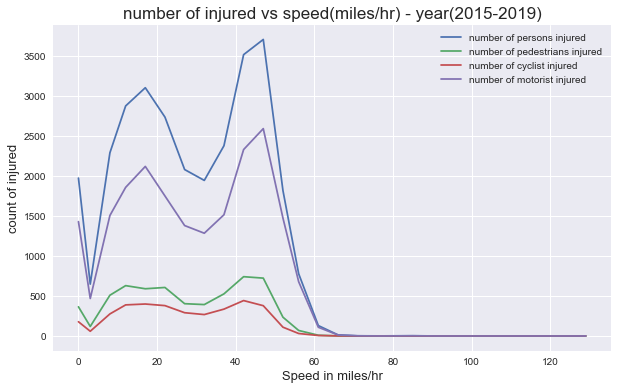

In [100]:
injrd_cols_to_lineplot = ['number_of_persons_injured', 'number_of_pedestrians_injured',    \
                    'number_of_cyclist_injured', 'number_of_motorist_injured']
title = 'number of injured vs speed(miles/hr) - year(' + str(years[0]) + '-'  + str(years[-1]) + ')'
multiline_plot(crahes_speed_years_grp, 'Speed', injrd_cols_to_lineplot, title=title, xlabel='')

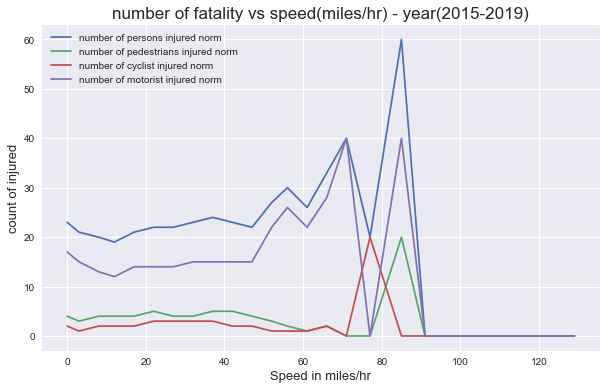

In [102]:
injrd_norm_cols_to_lineplot = ['number_of_persons_injured_norm', 'number_of_pedestrians_injured_norm',    \
                    'number_of_cyclist_injured_norm', 'number_of_motorist_injured_norm']
title = 'number of fatality vs speed(miles/hr) - year(' + str(years[0]) + '-'  + str(years[-1]) + ')'
multiline_plot(crahes_speed_years_grp, 'Speed', injrd_norm_cols_to_lineplot, title=title, xlabel='')

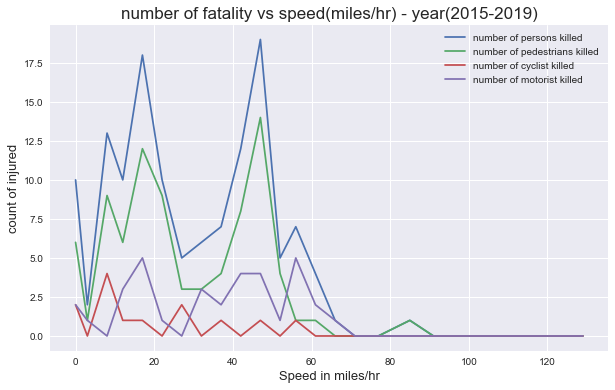

In [104]:
killed_cols_to_lineplot = ['number_of_persons_killed', 'number_of_pedestrians_killed',    \
                    'number_of_cyclist_killed', 'number_of_motorist_killed']
title = 'number of fatality vs speed(miles/hr) - year(' + str(years[0]) + '-'  + str(years[-1]) + ')'
multiline_plot(crahes_speed_years_grp, 'Speed', killed_cols_to_lineplot, title=title, xlabel='')

In [106]:
stats.pearsonr(crahes_speed_years['Speed'], crahes_speed_years['number_of_persons_injured'])

(0.021845890292671463, 2.2903559844267596e-15)

In [107]:
stats.ttest_ind(crahes_speed_years['Speed'], crahes_speed_years['number_of_persons_injured'])

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:211: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Ttest_indResult(statistic=0.0, pvalue=1.0)

In [108]:
stats.pearsonr(crahes_speed_years['Speed'], crahes_speed_years['number_of_persons_killed'])

(0.002920617711965125, 0.28945443328000775)

In [109]:
stats.ttest_ind(crahes_speed_years['Speed'], crahes_speed_years['number_of_persons_killed'])

Ttest_indResult(statistic=0.0, pvalue=1.0)

### Explore top roads in terms of crashes/fatality monitored by cctv

In [110]:
def crash_speed_link_relation(crashes, years):
    frames = [None] * len(years)
    crash_gdf = crashes.copy()
    for indx,year in enumerate(years):
        traffic_speed_yr = read_traffic_speed_data(ASSETS_PATH, year)
        traffic_speed_yr = traffic_speed_processing(traffic_speed_yr)

        crahes_speed_yr = pd.merge_asof(crash_gdf, traffic_speed_yr, left_on=['date'], \
                                          right_on=['speed_date'], by='linkId',                                    
                                            tolerance=pd.Timedelta('5min'))
        
        frames[indx] = crahes_speed_yr.groupby(['linkId']).agg({'number_of_persons_injured': np.sum,'number_of_persons_killed': np.sum,
                                            'number_of_pedestrians_injured':np.sum,'number_of_pedestrians_killed':np.sum,
                                            'number_of_cyclist_injured':np.sum,'number_of_cyclist_killed':np.sum,  
                                            'number_of_motorist_injured':np.sum,'number_of_motorist_killed':np.sum,  
                                            'collision_id':'count','Speed': 'mean'}).reset_index()
        
    frames = [frame for frame in frames if frame is not None]
    crahes_speed_grpd = pd.concat(frames)
    crahes_speed_grpd = crahes_speed_grpd.groupby(['linkId']).agg({'number_of_persons_injured': np.sum,'number_of_persons_killed': np.sum,
                                            'number_of_pedestrians_injured':np.sum,'number_of_pedestrians_killed':np.sum,
                                            'number_of_cyclist_injured':np.sum,'number_of_cyclist_killed':np.sum,  
                                            'number_of_motorist_injured':np.sum,'number_of_motorist_killed':np.sum,  
                                            'collision_id':'count','Speed': 'mean'}).reset_index()
    return(crahes_speed_grpd)

In [113]:
def draw_bar(df, category, num_col, title='', reverse=False):
    bars = alt.Chart(df).mark_bar(width=25).encode(
                y= alt.Y(f'{num_col}:Q',
                     title=f'{num_col}'),
                x = alt.X(f'{category}:N',
                     sort=col_order)
                )
    return(bars)

def draw_bar_col(df, category, num_col, title='', reverse=False):
    bars = alt.Chart(df).mark_bar(width=25).encode(
                y= alt.Y(f'{num_col}:Q',
                     title=f'{num_col}'),
                x = alt.X(f'{category}:N',
                     sort=col_order),
                color = alt.Color(f'{category}:N',
                        scale=alt.Scale(scheme='Spectral', reverse=reverse),
                        sort=col_order)
                )
    return(bars)

In [114]:
years = [2015, 2016, 2017, 2018, 2019]
crahes_speed_grpd = crash_speed_link_relation(crashes_gdf, years) 

title = 'number of persons injured in NYC'
crahes_speed_grpd = crahes_speed_grpd.sort_values(by='number_of_persons_injured',ascending=False).reset_index(drop=True).head(20)
col_order = crahes_speed_grpd.number_of_persons_injured.sort_values(ascending=False).to_list()

bar = draw_bar_col(crahes_speed_grpd, 'linkId','number_of_persons_injured')
text = draw_text(crahes_speed_grpd, 'linkId','number_of_persons_injured')
(bar + text).properties(width=800,height=300, title=title)

alt.LayerChart(...)

In [115]:
title = 'number of persons killed in NYC'
crahes_speed_grpd = crahes_speed_grpd.sort_values(by='number_of_persons_killed',ascending=False).reset_index(drop=True).head(20)
col_order = crahes_speed_grpd.number_of_persons_killed.sort_values(ascending=False).to_list()

bar = draw_bar_col(crahes_speed_grpd, 'linkId','number_of_persons_killed')
text = draw_text(crahes_speed_grpd, 'linkId','number_of_persons_killed')
(bar + text).properties(width=800,height=300, title=title)

alt.LayerChart(...)

In [119]:
crahes_speed_grpd_yr = crahes_speed_grpd
crahes_speed_grpd_poly = pd.merge(crahes_speed_grpd_yr, linkinfo_df, on='linkId', how='inner')
crahes_speed_grpd_poly = crahes_speed_grpd_poly.sort_values(by='number_of_persons_killed',ascending=False).reset_index(drop=True).head(20)
crahes_speed_grpd_poly.head(4)

,linkId,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,collision_id,Speed,linkPoints,EncodedPolyLine,EncodedPolyLineLvls,Borough,lat_max,lat_min,long_max,long_min
0,4620343,46875.0,245,12570,175,7230,20,27005,50,5,32.812500,"40.77149,-73.99423 40.7719,-73.99401 40.77481,...",ydzwF|~rbMqAk@eQyKkUkOyHiFgGgFyPaLgJ{FgJ_D}IsC...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB...,Manhattan,40.84983,40.77149,-73.94319,-73.99423
1,4616257,38035.0,115,7375,60,5910,15,24725,40,5,24.062500,"40.69153,-73.99911 40.6922605,-73.99937 40.692...",aqjwFl}sbMqCr@}B?yAWoCu@{DyAyM_F{KeEcAk@iAgA}@...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB...,Brooklyn,40.71759,40.69153,-73.94829,-73.99911
2,4616255,21785.0,90,3390,65,1265,0,17075,25,5,24.453125,"40.81376,-73.93128 40.8127206,-73.9316 40.8121...",_mbxFnufbMnE~@xBP|BOpBeA|A}ArLaQjBgElFiQjHiVvF...,BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB,Bronx,40.82408,40.80339,-73.87432,-73.91503
3,4616235,6665.0,60,460,20,410,10,5785,30,5,19.875000,"40.69153,-73.99911 40.6922605,-73.99937 40.692...",}sowFx_jbMwDgHuHgOgG}LqBkDmB}CeCeFoD{Hg@qAcAgG...,BBBBBBBBBBBBBBBBBBBBBBBBBB,Brooklyn,40.73499,40.71759,-73.92024,-73.94829


#### Plot link polyline for high crashes/fatality

In [120]:
def draw_polyline_link_crashes(data,linkinfo_df, linkId):
    crashes_df = data.copy()
    crashes_df = crashes_df[crashes_df['linkId'] == linkId]
    enc_poly = linkinfo_df[linkinfo_df['linkId'] == linkId].EncodedPolyLine.values[0]
    line = polyline.decode(enc_poly)
    coords = [[p[0] ,p[1]] for p in line ]
    coords_mid = coords[len(coords)//2]

    m = folium.Map(location=coords_mid,zoom_start = 13)
    folium.PolyLine(locations=line).add_to(m)
    for point in coords:
        folium.Marker(location=point).add_to(m)
    crash_coords = crashes_df.geometry.values[:5]
    for point in crash_coords:
        folium.Marker(location=[point.y, point.x], popup='crash_point').add_to(m)
    return(m)
linkId = crahes_speed_grpd_yr.linkId.values[1]
m = draw_polyline_link_crashes(crashes_gdf, linkinfo_df, linkId)
m

In [121]:
def draw_polyline(enc_poly):
    line = polyline.decode(enc_poly)
    coords = [[p[0] ,p[1]] for p in line ]
    coords_mid = coords[len(coords)//2]

    m = folium.Map(location=coords_mid,zoom_start = 14)
    folium.PolyLine(locations=line).add_to(m)
    for point in coords:
        folium.Marker(location=point).add_to(m)
    return(m)

m = draw_polyline(linkinfo_df['EncodedPolyLine'][30])
m

In [122]:
m = draw_polyline(linkinfo_df['EncodedPolyLine'][30])
m

## Q6. Traffic count / time relation with accidents for each zip code  <a class="anchor" id="q6_start"></a>

In [123]:
on_street = crashes_gdf.on_street_name.value_counts().to_dict()
cross_street = crashes_gdf.cross_street_name.value_counts().to_dict()
off_street = crashes_gdf.off_street_name.value_counts().to_dict()

street_combined = Counter(on_street) + Counter(cross_street) + Counter(off_street)

del street_combined['_Missing_']
roadway_crashes = pd.DataFrame(street_combined.most_common(100), columns=['roadway_name', 'crashes_count'])
roadway_crashes['roadway_name'] = roadway_crashes['roadway_name'].apply(lambda x: x.title())
roadway_crashes.head()

,roadway_name,crashes_count
0,2 Avenue,6062
1,3 Avenue,5670
2,Broadway,5490
3,Bruckner Boulevard,5207
4,Brooklyn Queens Expressway,5190


In [124]:
roadway_crashes_vol = roadway_crashes.merge(traffic_vol_roadway, on='roadway_name',how='inner')
roadway_crashes_vol['crashes_count_lg'] = np.log(roadway_crashes_vol['crashes_count'])
roadway_crashes_vol.head(5)

,roadway_name,crashes_count,traffic_vol,traffic_vol_lg,expressway,crashes_count_lg
0,2 Avenue,6062,27423.414141,10.219152,N,8.709795
1,3 Avenue,5670,12857.857520,9.461710,N,8.642944
2,Broadway,5490,9824.835185,9.192669,N,8.610684
3,Bruckner Boulevard,5207,22256.763889,10.010401,N,8.557759
4,Brooklyn Queens Expressway,5190,70464.027778,11.162858,Y,8.554489


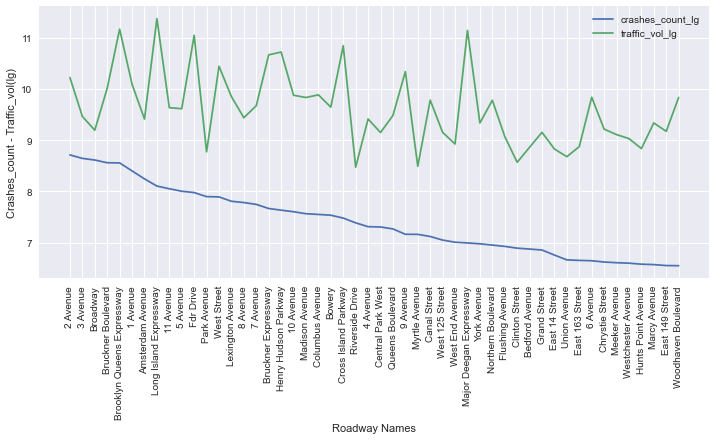

In [125]:
roadway_crashes_vol_50 = roadway_crashes_vol[:50]
plt.figure(figsize=(12,5))
plt.plot(roadway_crashes_vol_50['roadway_name'], roadway_crashes_vol_50['crashes_count_lg'], label='crashes_count_lg')
plt.plot(roadway_crashes_vol_50['roadway_name'], roadway_crashes_vol_50['traffic_vol_lg'], label='traffic_vol_lg')
plt.legend()
plt.xticks(rotation=90)
plt.xlabel('Roadway Names')
plt.ylabel('Crashes_count - Traffic_vol(lg)')
plt.show()

In [126]:
stats.pearsonr(roadway_crashes_vol['crashes_count'], roadway_crashes_vol['traffic_vol'])

(0.3854125661704384, 0.001660910018792032)

In [127]:
on_street_injured = crashes_gdf.groupby('on_street_name')['number_of_persons_injured'].sum().to_dict()
cross_street_injured = crashes_gdf.groupby('cross_street_name')['number_of_persons_injured'].sum().to_dict()
off_street_injured = crashes_gdf.groupby('off_street_name')['number_of_persons_injured'].sum().to_dict()

all_injured = Counter(on_street_injured) + Counter(cross_street_injured) + Counter(off_street_injured)
del all_injured['_Missing_']
all_injured = pd.DataFrame(all_injured.most_common(500), columns=['roadway_name', 'injured_count'])
all_injured.head()

,roadway_name,injured_count
0,Brooklyn Queens Expressway,1482.0
1,Bruckner Boulevard,1334.0
2,Broadway,1278.0
3,3 Avenue,1166.0
4,2 Avenue,1109.0


In [197]:
all_injured_roadway = all_injured.merge(traffic_vol_roadway, on='roadway_name', how='inner')
all_injured_roadway.head()

,roadway_name,injured_count,traffic_vol,traffic_vol_lg,expressway
0,Brooklyn Queens Expressway,1482.0,70464.027778,11.162858,Y
1,Bruckner Boulevard,1334.0,22256.763889,10.010401,N
2,Broadway,1278.0,9824.835185,9.192669,N
3,3 Avenue,1166.0,12857.857520,9.461710,N
4,2 Avenue,1109.0,27423.414141,10.219152,N


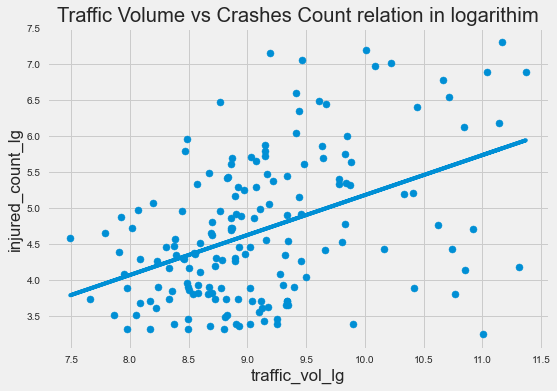

In [209]:
def draw_scatter_cor(col1, col2, data, title=''):
    m , b =np.polyfit(data[col1],  data[col2], 1)
    y = m * data[col1] + b
    plt.scatter(col1, col2, data=data)
    plt.plot(data[col1], y)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(title)
    plt.show()

all_injured_roadway = all_injured.merge(traffic_vol_roadway, on='roadway_name', how='inner')  \
                                        .drop(columns=['expressway'])
all_injured_roadway = all_injured_roadway.set_index('roadway_name')
all_injured_roadway = log_std_processing(all_injured_roadway)

title = 'Traffic Volume vs Crashes Count relation in logarithim'
draw_scatter_cor('traffic_vol_lg', 'injured_count_lg', all_injured_roadway, title=title)

In [130]:
stats.pearsonr(all_injured_roadway_50['injured_count'], all_injured_roadway_50['traffic_vol'])

(0.48844692737160567, 0.0003197647963976451)

In [131]:
title = 'On Street wise distribution of collision in NYC'
crashes_onStreet = crashes_gdf.groupby('on_street_name')['collision_id'].count()  \
                        .sort_values(ascending=False).reset_index()[:25]
mask = crashes_onStreet['on_street_name'] != '_Missing_'
col_order = crashes_onStreet.collision_id.sort_values(ascending=False).to_list()[:25]

bar = draw_bar(crashes_onStreet[mask], 'on_street_name','collision_id', title='')
text = draw_text(crashes_onStreet[mask], 'on_street_name','collision_id', title='')
(bar + text).properties(width=700,height=300, title=title)

alt.LayerChart(...)

In [132]:
title = 'Cross Street wise distribution of collision in NYC'
crashes_crossStreet = crashes_gdf.groupby('cross_street_name')['collision_id'].count() \
                        .sort_values(ascending=False).reset_index()[:25]
mask = crashes_crossStreet['cross_street_name'] != '_Missing_'
col_order = crashes_crossStreet.collision_id.sort_values(ascending=False).to_list()[:25]


bar = draw_bar(crashes_crossStreet[mask], 'cross_street_name','collision_id', title='')
text = draw_text(crashes_crossStreet[mask], 'cross_street_name','collision_id', title='')
(bar + text).properties(width=700,height=300, title=title)

alt.LayerChart(...)

In [133]:
title = 'Off-Street wise distribution of collision in NYC'
crashes_offStreet = crashes_gdf.groupby('off_street_name')['collision_id'].count()  \
                        .sort_values(ascending=False).reset_index()[:25]
mask = crashes_offStreet['off_street_name'] != '_Missing_'
col_order = crashes_offStreet.collision_id.sort_values(ascending=False).to_list()[:25]

bar = draw_bar(crashes_offStreet[mask], 'off_street_name','collision_id', title='')
text = draw_text(crashes_offStreet[mask], 'off_street_name','collision_id', title='')
(bar + text).properties(width=700,height=300, title=title)

alt.LayerChart(...)

In [134]:
heat_crashes = crashes_gdf[crashes_gdf['on_street_name'] =='Belt Parkway'].groupby(['latitude', 'longitude'])['collision_id'].sum().reset_index().values.tolist()
def geo_heatmap(city, data):
    point = city_geocoder(city)
    if not point:
        print('Please check the city/county name, Thank You.')
        return

    m = folium.Map(location=[point.y, point.x], zoom_start=11)
    folium.plugins.HeatMap(data).add_to(m)
    return(m)

city = 'New York'
case_heatmap = geo_heatmap(city, heat_crashes)
case_heatmap

In [135]:
heat_crashes = crashes_gdf[crashes_gdf['on_street_name'] =='Broadway'].groupby(['latitude', 'longitude'])['collision_id'].sum().reset_index().values.tolist()
def geo_heatmap(city, data):
    point = city_geocoder(city)
    if not point:
        print('Please check the city/county name, Thank You.')
        return

    m = folium.Map(location=[point.y, point.x], zoom_start=11)
    folium.plugins.HeatMap(data).add_to(m)
    return(m)

city = 'BROADWAY'
case_heatmap = geo_heatmap(city, heat_crashes)
case_heatmap

In [136]:
title = 'Contributing factor wise distribution of collision in NYC at "BELT PARKWAY" street'
crashes_onStreet = crashes_gdf[crashes_gdf['on_street_name'] == 'Belt Parkway'].groupby('contributing_factor_vehicle_1') \
                        ['collision_id'].count().sort_values(ascending=False).reset_index()[:10]
col_order = crashes_onStreet.collision_id.sort_values(ascending=False).to_list()[:10]

bar = draw_bar(crashes_onStreet, 'contributing_factor_vehicle_1','collision_id', title='')
text = draw_text(crashes_onStreet, 'contributing_factor_vehicle_1','collision_id', title='')
(bar + text).properties(width=700,height=300, title=title)

alt.LayerChart(...)

In [137]:
title = 'Contributing factor wise distribution of collision in NYC at BROADWAY street'
crashes_onStreet = crashes_gdf[crashes_gdf['on_street_name'] == 'Broadway'].groupby('contributing_factor_vehicle_1')  \
                    ['collision_id'].count().sort_values(ascending=False).reset_index()[:10]
col_order = crashes_onStreet.collision_id.sort_values(ascending=False).to_list()[:10]

bar = draw_bar(crashes_onStreet, 'contributing_factor_vehicle_1','collision_id', title='')
text = draw_text(crashes_onStreet, 'contributing_factor_vehicle_1','collision_id', title='')
(bar + text).properties(width=700,height=300, title=title)

alt.LayerChart(...)

## Q7. Could lives be saved by quicker medical attention, i.e. hospitals closer to accident sites? Are there any locations, which do not have hospitals nearby enough <a class="anchor" id="q7_start"></a>

In [138]:
hospitals_gdf = gpd.read_file("input/Hospitals-shp/Hospitals.shp")
hospitals_gdf = hospitals_gdf.to_crs(epsg=4326)
hospitals_gdf.head(2)

,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry
0,1,0005793230,CENTRAL VALLEY GENERAL HOSPITAL,1025 NORTH DOUTY STREET,HANFORD,CA,93230,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,...,http://www.hanfordhealth.com,NOT AVAILABLE,NOT AVAILABLE,06,PROPRIETARY,-999,49.0,NOT AVAILABLE,N,POINT (-119.64567 36.33616)
1,2,0053391362,LOS ROBLES HOSPITAL & MEDICAL CENTER - EAST CA...,150 VIA MERIDA,WESTLAKE VILAGE,CA,91362,NOT AVAILABLE,NOT AVAILABLE,GENERAL ACUTE CARE,...,http://www.losrobleshospital.com,NOT AVAILABLE,NOT AVAILABLE,06,PROPRIETARY,-999,62.0,NOT AVAILABLE,N,POINT (-118.81574 34.15494)


### When was the closest hospital more than 3 miles away?

Now say, if two miles is a buffer zone, inside which victims can be transported easily and saved.
Then lets find out the number of cases, when closest hospital was more than two miles away.

#### Pre-processing the hospital dataset

In [139]:
hospitals_gdf = data_cleaning(hospitals_gdf)
hospitals_gdf = hospitals_gdf[(hospitals_gdf['state'] == 'NY') & (hospitals_gdf['status'] == 'OPEN')]

visualize_data_mcgroup('New York', hospitals_gdf)

#### Change the coordinate reference system so as to compute the distance

In [140]:
crashes_gdf = crashes_gdf.to_crs('epsg:3627')
hospitals_gdf = hospitals_gdf.to_crs('epsg:3627')
hospitals_gdf.head(2)

,objectid,id,name,address,city,state,zip,zip4,telephone,type,...,website,state_id,alt_name,st_fips,owner,ttl_staff,beds,trauma,helipad,geometry
262,264,0002912601,VASSAR BROTHERS MEDICAL CENTER,45 READE PL,POUGHKEEPSIE,NY,12601,NOT AVAILABLE,(845) 454-8500,GENERAL ACUTE CARE,...,http://www.healthquest.org/poughkeepsie/vassar...,1302001H,NOT AVAILABLE,36,NON-PROFIT,-999,365.0,LEVEL II,Y,POINT (305346.146 169604.895)
263,265,0003214215,ERIE COUNTY MEDICAL CENTER,462 GRIDER ST,BUFFALO,NY,14215,NOT AVAILABLE,(716) 898-3000,GENERAL ACUTE CARE,...,http://www.ecmc.edu,1401005H,NOT AVAILABLE,36,GOVERNMENT - DISTRICT/AUTHORITY,-999,550.0,LEVEL I,Y,POINT (-94473.137 317293.030)


In [141]:
def create_buffer(hospital, feet):
    '''creates a buffer zone of provided km range
    hospital - dataframe containing hospital data
    km_range - range in kms, of which buffer needs to be created '''
    x_km_buffer = hospital.geometry.buffer(feet)
    my_union = x_km_buffer.geometry.unary_union
    return(my_union)

def outside_buffer_range(buffer, accidents, *args):
    '''finds the accidents which occurred outside buffer zone
    buffer - buffer zone dataframe created
    accidents - dataframe of accidents records'''
    if args:
        year,month = args 
        accidents = accidents[(accidents['year'] == year) & (accidents['month'] == month)]
    outside_range = accidents[~accidents['geometry'].progress_apply(lambda x: buffer.contains(x))]
    return(outside_range)    

mile_2 = 1 * 5280
hospital_buffer = create_buffer(hospitals_gdf, mile_2)

#### Check the number of accidents outside of one mile of safe hispital passage range
 - First lets check for one month, say Jul-18

In [142]:
outside_range = outside_buffer_range(hospital_buffer, crashes_gdf, 2018, 7)
print("Number of accidents outside of 3 miles buffer range for year {} for month {}: {}".format(2019, 12, outside_range.shape[0]))

  0%|          | 0/3526 [00:00<?, ?it/s]

Number of accidents outside of 3 miles buffer range for year 2019 for month 12: 20


#### Now lets validate the results by finding out the distance
 - For few collisions in outside range

In [143]:
outside_range = outside_range.reset_index(drop=True)
for indx in range(5):
    print(round(hospitals_gdf.geometry.distance(outside_range.iloc[indx].geometry).min(), 2), 'Feet')

8201.81 Feet
8346.07 Feet
7837.9 Feet
6635.9 Feet
8320.07 Feet


#### Lets further validate by plotting the collisions in outside range

In [144]:
x_mile_buffer = hospitals_gdf.geometry.buffer(5280)
m = folium.Map(location=[40.70, -73.94], zoom_start=10)
for indx in range(20):
    folium.Marker(location=[outside_range.iloc[indx].latitude,outside_range.iloc[indx].longitude]).add_to(m)
GeoJson(x_mile_buffer.to_crs(epsg=4326)).add_to(m)
m

#### Now that we are sure of correctness of our results

In [145]:
outside_range = outside_buffer_range(hospital_buffer, crashes_gdf)
print("Number of accidents outside of one mile buffer range for year 2012-2021 {}".format(outside_range.shape[0]))

  0%|          | 0/200215 [00:00<?, ?it/s]

Number of accidents outside of one mile buffer range for year 2012-2021 743


In [146]:
x_mile_buffer = hospitals_gdf.geometry.buffer(5280)
m = folium.Map(location=[40.70, -73.94], zoom_start=10)
for indx in range(200):
    folium.Marker(location=[outside_range.iloc[indx].latitude,outside_range.iloc[indx].longitude]).add_to(m)
GeoJson(x_mile_buffer.to_crs(epsg=4326)).add_to(m)
m

In [217]:
%reload_ext watermark
%watermark -v -m -p pandas,numpy,matplotlib,seaborn,altair,polyline,requests,shapely,folium,geopandas,tqdm,bs4,scipy,re

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

pandas    : 1.2.4
numpy     : 1.20.1
matplotlib: 3.3.4
seaborn   : 0.11.1
altair    : 4.1.0
polyline  : 1.4.0
requests  : 2.25.1
shapely   : 1.7.1
folium    : 0.0.0
geopandas : 0.9.0
tqdm      : 4.59.0
bs4       : 4.9.3
scipy     : 1.6.2
re        : 2.2.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : AMD64 Family 25 Model 33 Stepping 0, AuthenticAMD
CPU cores   : 12
Architecture: 64bit

